In [1]:
from skimage import data, transform
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.metrics import structural_similarity as ssim

import numpy as np
from scipy.spatial.distance import euclidean, cosine

import cv2
import matplotlib.pyplot as plt
from skimage import data, transform

import heapq
from collections import defaultdict
import random
import string

from collections import defaultdict, deque
import heapq

# PLOTS

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import joblib
import random
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.transform import rotate
import matplotlib.pyplot as plt
import os
import shutil
from torchvision.utils import save_image
import seaborn as sns
from matplotlib.patches import Patch
from scipy.spatial.distance import cdist
from scipy.ndimage import gaussian_filter
import seaborn as sns
from torchvision import datasets
import cv2
from skimage.metrics import structural_similarity as ssim
from skimage.transform import rotate
import random
from pytorch_msssim import ms_ssim
from PIL import Image
import torchvision.datasets as torchDatasets
import torch
import random
import cv2

### Transformations

In [3]:
def blur_image(image, percentage=10):
    h, w = image.shape[:2]  # Get image dimensions

    # Compute kernel size based on image dimensions and percentage
    k_h = max(1, int(h * (percentage / 100)))  # Kernel height
    k_w = max(1, int(w * (percentage / 100)))  # Kernel width

    # Ensure kernel sizes are odd (GaussianBlur requires odd kernel size)
    k_h = k_h + 1 if k_h % 2 == 0 else k_h
    k_w = k_w + 1 if k_w % 2 == 0 else k_w

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(image, (k_w, k_h), 0)
    return blurred.astype(image.dtype)  # Preserve dtype


def elastic_transform(image, alpha, sigma=1, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    Supports both grayscale (single-band) and RGB (multi-channel) images.
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    # Check if grayscale or RGB
    is_rgb = len(image.shape) == 3 and image.shape[-1] == 3
    shape = image.shape[:2]  # Spatial shape (height, width)

    # Generate displacement fields
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    # Meshgrid for coordinate mapping
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))  # Note: meshgrid uses (width, height) order
    indices = (y + dy, x + dx)  # Tuple of deformed coordinates

    if is_rgb:
        # Apply transformation to each channel separately and stack
        transformed = np.stack([
            map_coordinates(image[:, :, i], indices, order=1, mode="reflect")
            for i in range(3)
        ], axis=-1)
    else:
        # Apply transformation to grayscale image
        transformed = map_coordinates(image, indices, order=1, mode="reflect")

    return transformed.astype(image.dtype)  # Preserve original dtype

# Function to rotate and crop an image

def rotate_and_crop(image, angle):
    # Rotate the image
    rotated_image = rotate(image, angle, resize=True, mode='edge', preserve_range=True)

    # Get the original and rotated dimensions
    orig_h, orig_w = image.shape[:2]
    rot_h, rot_w = rotated_image.shape[:2]

    # Compute center coordinates
    center_x, center_y = rot_h // 2, rot_w // 2
    
    # Compute cropping boundaries (handling odd and even cases)
    crop_x1 = center_x - (orig_h // 2)
    crop_x2 = crop_x1 + orig_h
    crop_y1 = center_y - (orig_w // 2)
    crop_y2 = crop_y1 + orig_w

    # Ensure cropping dimensions are within valid range
    crop_x1, crop_x2 = max(0, crop_x1), min(rot_h, crop_x2)
    crop_y1, crop_y2 = max(0, crop_y1), min(rot_w, crop_y2)

    # Perform cropping
    cropped_image = rotated_image[crop_x1:crop_x2, crop_y1:crop_y2]

    # Ensure output dimensions match the original image exactly
    if cropped_image.shape[:2] != (orig_h, orig_w):
        cropped_image = cv2.resize(cropped_image, (orig_w, orig_h), interpolation=cv2.INTER_LINEAR)

    return cropped_image.astype(np.uint8)
    
# Function to add Gaussian noise
def add_gaussian_noise(image, std):
    noise = np.random.normal(0, std, image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 255)  # Clip values to valid image range

def apply_jpeg_compression(image, quality=50):
    """Applies JPEG compression by encoding and decoding."""
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    _, encimg = cv2.imencode('.jpg', image, encode_param)
    return cv2.imdecode(encimg, cv2.IMREAD_COLOR)

def adjust_contrast(image, alpha=1.2, beta=0):
    """Adjusts contrast using alpha (gain) and beta (bias)."""
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

def adjust_brightness(image, beta=50):
    """Adjusts brightness by adding a scalar beta."""
    return cv2.convertScaleAbs(image, beta=beta)

def change_saturation(image, scale=1.5):
    """Changes image saturation by scaling the S-channel in HSV."""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV).astype(np.float32)
    hsv[..., 1] *= scale  # Adjust saturation
    hsv[..., 1] = np.clip(hsv[..., 1], 0, 255)  # Ensure valid range
    return cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)

def change_hue(image, shift=30):
    """Shifts the hue value in HSV space."""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV).astype(np.float32)
    hsv[..., 0] = (hsv[..., 0] + shift) % 180  # Wrap hue values
    return cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)

def apply_motion_blur(image, kernel_size=15):
    """Applies motion blur using a linear kernel."""
    kernel = np.zeros((kernel_size, kernel_size))
    kernel[int((kernel_size - 1) / 2), :] = np.ones(kernel_size)
    kernel /= kernel_size
    return cv2.filter2D(image, -1, kernel)

def apply_perspective_transform(image):
    """Applies a perspective transformation simulating camera angle changes."""
    h, w = image.shape[:2]
    src_pts = np.float32([[0, 0], [w, 0], [0, h], [w, h]])
    dst_pts = np.float32([[w * 0.1, h * 0.2], [w * 0.9, h * 0.1], [w * 0.2, h * 0.9], [w * 0.8, h * 0.8]])
    matrix = cv2.getPerspectiveTransform(src_pts, dst_pts)
    return cv2.warpPerspective(image, matrix, (w, h))

def apply_occlusion(image, mask_size=0.3):
    """Applies occlusion by covering part of the image with a black rectangle."""
    h, w = image.shape[:2]
    x, y = np.random.randint(0, w * (1 - mask_size)), np.random.randint(0, h * (1 - mask_size))
    mask_w, mask_h = int(w * mask_size), int(h * mask_size)
    occluded_image = image.copy()
    occluded_image[y:y+mask_h, x:x+mask_w] = 0  # Black occlusion
    return occluded_image

def apply_scaling(image, scale=0.5):
    """Downscales an image while maintaining aspect ratio."""
    h, w = image.shape[:2]
    return cv2.resize(image, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_LINEAR)


### SIFT

In [4]:
def calculate_sift_match_index(image1, image2):
    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect and compute keypoints and descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

    if descriptors1 is None or descriptors2 is None:
        return 0  # Return 0 if descriptors could not be computed

    # Convert descriptors to np.float32 if necessary
    if descriptors1.dtype != np.float32:
        descriptors1 = descriptors1.astype(np.float32)
    if descriptors2.dtype != np.float32:
        descriptors2 = descriptors2.astype(np.float32)

    # Match features using FLANN matcher
    flann_index_kdtree = 1
    index_params = dict(algorithm=flann_index_kdtree, trees=5)
    search_params = dict(checks=50)

    matcher = cv2.FlannBasedMatcher(index_params, search_params)
    matches = matcher.knnMatch(descriptors1, descriptors2, k=2)

    # Ratio test
    good_matches = [m for m, n in matches if m.distance < 1 * n.distance]

    # Normalize indices
    num_keypoints1 = len(keypoints1)
    num_keypoints2 = len(keypoints2)
    num_good_matches = len(good_matches)

    if (num_keypoints1 + num_keypoints2) == 0:
        return 0

    return num_good_matches / (num_keypoints1 + num_keypoints2)

### MESI

In [5]:
import numpy as np
from scipy.ndimage import grey_dilation, grey_erosion

def compute_mesi(image1, image2, kernel_size=3):
    """
    Compute the Morphological Edge Similarity Index (MESI) between two images using morphological gradient.

    Parameters:
    - image1: First input image (grayscale).
    - image2: Second input image (grayscale).
    - kernel_size: Size of the morphological structuring element (default=3).

    Returns:
    - MESI: Morphological Edge Similarity Index (score between 0 and 1).
    """
    gray1 = .3 * image1[:,:,0] + .6 * image1[:,:,1] + .1 * image1[:,:,2]
    gray2 = .3 * image2[:,:,0] + .6 * image2[:,:,1] + .1 * image2[:,:,2]
    
    # Normalize images to range [0, 1]
    image1 = gray1.astype(np.float32) / 255.0
    image2 = gray2.astype(np.float32) / 255.0

    # Define the structuring element (square kernel)
    structuring_element = np.ones((kernel_size, kernel_size))

    # Compute morphological gradient (dilation - erosion)
    edges1 = grey_dilation(image1, footprint=structuring_element) - grey_erosion(image1, footprint=structuring_element)
    edges2 = grey_dilation(image2, footprint=structuring_element) - grey_erosion(image2, footprint=structuring_element)

    # Compute edge correspondence
    total_edges1 = np.sum(edges1)
    total_edges2 = np.sum(edges2)

    if total_edges1 == 0 or total_edges2 == 0:
        return 0  # Avoid division by zero

    common_edges = np.sum(edges1 * edges2)

    # Compute MESI
    mesi_score = (2 * common_edges) / (total_edges1 + total_edges2)
    
    return mesi_score

### ESSIM

In [6]:
from scipy.ndimage import convolve

def compute_essim2(image1, image2):
    """
    Compute the Edge Strength Similarity Index (ESSIM) between two images.

    Parameters:
    - image1: First input image (grayscale).
    - image2: Second input image (grayscale).

    Returns:
    - ESSIM: Edge Strength Similarity Index (score between 0 and 1).
    """
    gray1 = .3 * image1[:,:,0] + .6 * image1[:,:,1] + .1 * image1[:,:,2]
    gray2 = .3 * image2[:,:,0] + .6 * image2[:,:,1] + .1 * image2[:,:,2]
    
    # Normalize images to range [0, 1]
    image1 = gray1.astype(np.float32) / 255.0
    image2 = gray2.astype(np.float32) / 255.0

    # Scharr operator kernels for edge detection
    scharr_x = np.array([[-3, 0, 3], [-10, 0, 10], [-3, 0, 3]], dtype=np.float32) / 16
    scharr_y = np.array([[-3, -10, -3], [0, 0, 0], [3, 10, 3]], dtype=np.float32) / 16

    # Compute edge strengths
    edge_x1 = convolve(image1, scharr_x)
    edge_y1 = convolve(image1, scharr_y)
    edge_x2 = convolve(image2, scharr_x)
    edge_y2 = convolve(image2, scharr_y)

    # Compute edge magnitude
    E_X = np.sqrt(edge_x1**2 + edge_y1**2)
    E_Y = np.sqrt(edge_x2**2 + edge_y2**2)

    # ESSIM computation
    C = 1e-6  # Small constant to avoid division by zero
    numerator = 2 * E_X * E_Y + C
    denominator = E_X**2 + E_Y**2 + C

    essim_map = numerator / denominator
    essim_score = np.mean(essim_map)

    return essim_score


### WPGSI

In [18]:
from graph_hierarchy import get_initial_points, get_initial_arcs
from graph_hierarchy import generate_hierarchical_graph, watershed_partition
from graph_hierarchy import create_graph_from_image, eta

from scipy.optimize import linear_sum_assignment

def generate_hierarchy(image, connectivity=8):
    # Lists to store hierarchical data
    arc0_pointCount_hierarchy = []
    arc0_pointDegree_hierarchy = []    
    flatzone_NbrCount_hierarchy = []   
    flatzone_size_hierarchy = []  

    graph_hierarchy = []        # List of graphs for each level
    fzpair_arcNodes_dict_hierarchy = []     # List of arc dictionaries for each level
    id_fzPair_dict_hierarchy = []  # List of ID-to-flat zone pair mappings

    # Generate level-0 graph
    graph_0, map_id_to_cord_0, reconstructed_image = create_graph_from_image(
        image, connectivity=connectivity, metric='euclidean'
    )

    id_fzPair_dict_hierarchy.append(map_id_to_cord_0)
    graph_hierarchy.append(graph_0)

    h, w = image.shape[:2]

    initial_points = get_initial_points(graph_0)
    fzpair_arcNodes_dict, fzpair_arcInfo_dict, flatzone_nbrArcs_dict, flatzone_valueinfo_dict = get_initial_arcs(graph_hierarchy[0],initial_points)

    partitionImages = []
    level = 0
    while True:   
        if not fzpair_arcNodes_dict:
            break  
        fzpair_arcNodes_dict_hierarchy.append(fzpair_arcNodes_dict)

        # -----------------------------------------
        coordinates=[]
        arc0_hierarchy=[]
        for arc in fzpair_arcNodes_dict:
            E = list( eta(arc, fzpair_arcNodes_dict_hierarchy, id_fzPair_dict_hierarchy, level=level))
            coordinates.extend(E)
            arc0_hierarchy.append(E)
        level += 1
        
        arc0_pointCount_hierarchy.append([len(c) for c in arc0_hierarchy])  
        arc0_pointDegree_hierarchy.append([(len(A)-2)*2+6 if len(A)>2 else 2 if len(A)==2 else 0 for A in arc0_hierarchy])
        flatzone_NbrCount_hierarchy.append([len(flatzone_nbrArcs_dict[F]) for F in flatzone_nbrArcs_dict])
        flatzone_size_hierarchy.append([fz_nodes['count'] for fz_nodes in flatzone_valueinfo_dict.values()])
        
        w_image=np.ones((image.shape[0],image.shape[1]))
        for c in coordinates:
            w_image[c]=0
        partitionImages.append(w_image)
        # -----------------------------------------
        
        graph, id_to_fzPair = generate_hierarchical_graph(fzpair_arcNodes_dict, flatzone_nbrArcs_dict, flatzone_valueinfo_dict)
        graph_hierarchy.append(graph)
        id_fzPair_dict_hierarchy.append(id_to_fzPair)

        # Partition the current graph
        fzpair_arcNodes_dict, fzpair_arcInfo_dict, flatzone_nbrArcs_dict, flatzone_valueinfo_dict = watershed_partition(graph,
                                                  fzpair_arcInfo_dict, flatzone_valueinfo_dict, id_to_fzPair, reintroduce_factor=0)

    total_nodes = h*w
    # Prepare the hierarchical data dictionary
    hierarchy = {
        'arc0_pointCount_hierarchy' : arc0_pointCount_hierarchy,
        'arc0_pointDegree_hierarchy' : arc0_pointDegree_hierarchy,
        'flatzone_NbrCount_hierarchy': flatzone_NbrCount_hierarchy,
        'flatzone_size_hierarchy': flatzone_size_hierarchy,
        'total_nodes': total_nodes
    }
    return hierarchy, partitionImages
def compute_partition_similarity(partition_sizes_1, partition_sizes_2, level_matches):
    """
    Compute Partition Shape Similarity (S_P) between two hierarchical graph partitions.
    
    Parameters:
    - partition_sizes_1: Dictionary {level: list of partition sizes} for Graph-1.
    - partition_sizes_2: Dictionary {level: list of partition sizes} for Graph-2.
    - level_matches: List of optimal (l, k) level matches between Graph-1 and Graph-2.
    
    Returns:
    - S_P: Dictionary {(l, k): similarity_score} for matched levels.
    """
    S_P = {}

    for (l, k) in level_matches:
        if l in partition_sizes_1 and k in partition_sizes_2:
            mean_size_1 = np.mean(partition_sizes_1[l])
            mean_size_2 = np.mean(partition_sizes_2[k])
            
            similarity = 1 - abs(mean_size_1 - mean_size_2) / max(mean_size_1, mean_size_2)
            S_P[(l, k)] = max(0, similarity)  # Ensure non-negative similarity
    
    return S_P
def compute_spectral_similarity(degrees_1, degrees_2, level_matches):
    """
    Compute Spectral Signature Similarity (S_lambda) using node degree distributions.

    Parameters:
    - degrees_1: Dictionary {level: list of degrees} for Graph-1.
    - degrees_2: Dictionary {level: list of degrees} for Graph-2.
    - level_matches: List of optimal (l, k) level matches between Graph-1 and Graph-2.

    Returns:
    - S_lambda: Dictionary {(l, k): similarity_score} for matched levels.
    """

    S_lambda = {}

    for (l, k) in level_matches:
        if l in degrees_1 and k in degrees_2:
            # Compute mean and variance of degree distributions
            mean_lambda_1 = np.mean(degrees_1[l])
            mean_lambda_2 = np.mean(degrees_2[k])
            var_lambda_1 = np.var(degrees_1[l])
            var_lambda_2 = np.var(degrees_2[k])

            # Spectral similarity: exponential decay function of mean and variance differences
            similarity = np.exp(-abs(mean_lambda_1 - mean_lambda_2)) * np.exp(-abs(var_lambda_1 - var_lambda_2))

            S_lambda[(l, k)] = similarity

    return S_lambda
def compute_vertex_cut_similarity(vertex_cuts_1, vertex_cuts_2, level_matches):
    """
    Compute Vertex Cut Similarity (S_C) by comparing degree sums of removed nodes.
    
    Parameters:
    - vertex_cuts_1: Dictionary {level: list of removed node degrees} for Graph-1.
    - vertex_cuts_2: Dictionary {level: list of removed node degrees} for Graph-2.
    - level_matches: List of optimal (l, k) level matches between Graph-1 and Graph-2.
    
    Returns:
    - S_C: Dictionary {(l, k): similarity_score} for matched levels.
    """
    S_C = {}
    for (l, k) in level_matches:
        if l in vertex_cuts_1 and k in vertex_cuts_2:
            D_1 = np.sum(vertex_cuts_1[l])  # Sum of degrees of removed nodes
            D_2 = np.sum(vertex_cuts_2[k])

            similarity = np.exp(-abs(D_1 - D_2))
            S_C[(l, k)] = similarity
    
    return S_C
def compute_level_matches(L1, L2, cost_matrix=None):
    """
    Compute the optimal level matches between Graph-1 (L1 levels) and Graph-2 (L2 levels).
    
    Parameters:
    - L1: Number of hierarchical levels in Graph-1.
    - L2: Number of hierarchical levels in Graph-2.
    - cost_matrix: Optional custom cost matrix of shape (L1, L2), if available.
    
    Returns:
    - level_matches: List of optimal (l, k) matches between levels of Graph-1 and Graph-2.
    """
    if cost_matrix is None:
        cost_matrix = np.abs(np.subtract.outer(range(L1), range(L2)))  # Default cost: absolute level difference

    row_ind, col_ind = linear_sum_assignment(cost_matrix)  # Hungarian algorithm for optimal matching
    level_matches = list(zip(row_ind, col_ind))

    return level_matches 
def compute_structural_similarity(level_matches, S_P, S_lambda, S_C, alpha=1.0, beta=1.0, gamma=1.0):
    """
    Computes the normalized Structural Similarity Index (SSI) between two hierarchical graph partitions.
    
    Parameters:
    - level_matches: List of tuples [(l, k)] where l is a level in Graph-1, and k is a level in Graph-2.
    - S_P: Dictionary {(l, k): value} storing Partition Shape Similarity scores.
    - S_lambda: Dictionary {(l, k): value} storing Spectral Signature Similarity scores.
    - S_C: Dictionary {(l, k): value} storing Vertex Cut Similarity scores.
    - alpha: Weight for Partition Shape Similarity (default=1.0).
    - beta: Weight for Spectral Similarity (default=1.0).
    - gamma: Weight for Vertex Cut Similarity (default=1.0).
    
    Returns:
    - SSI_final: Normalized structural similarity index (0 to 1).
    """
    numerator = 0
    denominator = 0
    
    for (l, k) in level_matches:
        # Exponential weighting to prioritize higher levels
        weight = np.exp(-min(l, k))
        
        # Compute weighted sum of similarity measures
        similarity_score = alpha * S_P.get((l, k), 0) + beta * S_lambda.get((l, k), 0) + gamma * S_C.get((l, k), 0)
        
        numerator += weight * similarity_score
        denominator += weight * (alpha + beta + gamma)
    
    # Normalize SSI (avoid division by zero)
    SSI_final = numerator / denominator if denominator != 0 else 0
    
    return SSI_final
def calculate_similarity_IWP(hierarchy1, hierarchy2, normalize=True):
    # Extract data
    arc0_pointCount_hierarchy1, arc0_pointDegree_hierarchy1, flatzone_NbrCount_hierarchy1, flatzone_size_hierarchy1, total_nodes1 = (
        hierarchy1['arc0_pointCount_hierarchy'], 
        hierarchy1['arc0_pointDegree_hierarchy'], 
        hierarchy1['flatzone_NbrCount_hierarchy'], 
        hierarchy1['flatzone_size_hierarchy'], 
        hierarchy1['total_nodes']
    )
    arc0_pointCount_hierarchy2, arc0_pointDegree_hierarchy2, flatzone_NbrCount_hierarchy2, flatzone_size_hierarchy2, total_nodes2 = (
        hierarchy2['arc0_pointCount_hierarchy'], 
        hierarchy2['arc0_pointDegree_hierarchy'], 
        hierarchy2['flatzone_NbrCount_hierarchy'], 
        hierarchy2['flatzone_size_hierarchy'], 
        hierarchy2['total_nodes']
    )

    arc0_pointCount_hierarchy1 = [[i / total_nodes1 for i in I] for I in arc0_pointCount_hierarchy1]
    arc0_pointDegree_hierarchy1 = [[i / total_nodes1 for i in I] for I in arc0_pointDegree_hierarchy1]
    flatzone_NbrCount_hierarchy1 = [[i / total_nodes1 for i in I] for I in flatzone_NbrCount_hierarchy1]
    flatzone_size_hierarchy1 = [[i / total_nodes1 for i in I] for I in flatzone_size_hierarchy1]
    
    arc0_pointCount_hierarchy2 = [[i / total_nodes2 for i in I] for I in arc0_pointCount_hierarchy2]
    arc0_pointDegree_hierarchy2 = [[i / total_nodes2 for i in I] for I in arc0_pointDegree_hierarchy2]
    flatzone_NbrCount_hierarchy2 = [[i / total_nodes2 for i in I] for I in flatzone_NbrCount_hierarchy2]
    flatzone_size_hierarchy2 = [[i / total_nodes2 for i in I] for I in flatzone_size_hierarchy2]
    
    level_matches = compute_level_matches(len(arc0_pointCount_hierarchy1),len(arc0_pointCount_hierarchy2))
    S_C = compute_vertex_cut_similarity({i:arc0_pointDegree_hierarchy1[i] for i in range(len(arc0_pointDegree_hierarchy1))}, 
                                        {i:arc0_pointDegree_hierarchy2[i] for i in range(len(arc0_pointDegree_hierarchy2))}, 
                                        level_matches)
    S_lambda = compute_spectral_similarity({i:flatzone_NbrCount_hierarchy1[i] for i in range(len(flatzone_NbrCount_hierarchy1))}, 
                                           {i:flatzone_NbrCount_hierarchy2[i] for i in range(len(flatzone_NbrCount_hierarchy2))}, 
                                           level_matches)
    S_P = compute_partition_similarity({i:flatzone_size_hierarchy1[i] for i in range(len(flatzone_size_hierarchy1))}, 
                                       {i:flatzone_size_hierarchy2[i] for i in range(len(flatzone_size_hierarchy2))}, 
                                       level_matches)

    return compute_structural_similarity(level_matches, S_P, S_lambda, S_C)

def proposed_similarity_IWPmultiband(image1,image2,connectivity=8):
    hierarchy1, _ = generate_hierarchy(image1, connectivity=connectivity)
    # print(hierarchy1)
    hierarchy2, _ = generate_hierarchy(image2, connectivity=connectivity)
    # print(hierarchy2)
    return calculate_similarity_IWP(hierarchy1, hierarchy2)

## results generation

In [37]:
# Log-Polar transformation function
def log_polar(image):
    center = (image.shape[1] // 2, image.shape[0] // 2)
    max_radius = np.sqrt(center[0] ** 2 + center[1] ** 2)
    return cv2.logPolar(image, center, max_radius, cv2.INTER_LINEAR)

def compute_ms_ssim(I1, I2):
    transform = transforms.ToTensor()
    I1_tensor = transform(I1).unsqueeze(0)  # Add batch dimension
    I2_tensor = transform(I2).unsqueeze(0)  # Add batch dimension
    ms_ssim_score = ms_ssim(I1_tensor, I2_tensor, data_range=1.0, size_average=True)
    return ms_ssim_score.item()
    
def getSimilarityScore(I1,I2,M):
    if M=='SSIM':
        return ssim(I1, I2, data_range=255, multichannel=True,channel_axis=2)
    if M=='MS-SSIM':
        if min(I1.shape[0],I1.shape[1]) <= 160:
            scale_factor_I1 = 170/min(I1.shape[0],I1.shape[1])
            I1 = cv2.resize(I1, (int(I1.shape[1] * scale_factor_I1), int(I1.shape[0] * scale_factor_I1)), interpolation=cv2.INTER_LINEAR)
        if min(I2.shape[0],I2.shape[1]) <= 160:
            scale_factor_I2 = 170/min(I2.shape[0],I2.shape[1])
            I2 = cv2.resize(I2, (int(I2.shape[1] * scale_factor_I2), int(I2.shape[0] * scale_factor_I2)), interpolation=cv2.INTER_LINEAR)
        # print("scale_factor_I1",scale_factor_I1,"scale_factor_I2",scale_factor_I2)
        I1, I2 = I1.astype(np.uint8), I2.astype(np.uint8)
        return compute_ms_ssim(I1, I2)
    if M=='Log-polar':
        log_polar_image1 = log_polar(I1)
        log_polar_image2 = log_polar(I2)
        log_polar_similarity = cv2.matchTemplate(log_polar_image1, log_polar_image2, cv2.TM_CCOEFF_NORMED)
        return log_polar_similarity.mean()
    if M=='SIFT':
        return calculate_sift_match_index(I1, I2)
    if M=='WPGSI':
        return proposed_similarity_IWPmultiband(I1.astype(np.float32),I2.astype(np.float32),connectivity=8)
    if M=='MESI':
        return compute_mesi(I1,I2)
    if M=='ESSIM':
        return compute_essim2(I1,I2)

In [1]:
train_dataset = torchDatasets.ImageFolder(root=os.path.join('..','datasets','imagenette2-160', 'train'), transform=None )
# train_dataset = datasets.CIFAR10(root='../datasets', train=True, transform=None, download=False)
# train_dataset = datasets.MNIST(root='../datasets', train=True, transform=None, download=False)

num_images = 1000
random_indices = random.sample(range(len(train_dataset)), num_images)  # Sample fixed indices

random_images = [np.array(train_dataset[idx][0]) for idx in random_indices]

In [2]:
transformation_levels = {
    "Scaling": [90, 70, 50, 30],
    "Gaussian Noise": [10, 30, 50, 70],
    "Rotation": [15, 30, 60, 90],
    "Blur": [5, 10, 15, 20],
    "JPEG Compression": [90, 60, 30, 10],
}

methods = ['SSIM','MS-SSIM', 'SIFT', 'MESI', 'ESSIM', 'WPGSI'] 

similarity_results = {M: {key: {level: [] for level in levels} for key, levels in transformation_levels.items()} for M in methods}
C = {M: {key: {level: 0 for level in levels} for key, levels in transformation_levels.items()} for M in methods}

for i,I in enumerate(random_images):
    H, P = generate_hierarchy(I.astype(np.float32))
    for transformation, levels in transformation_levels.items():
        for level in levels:
            print(i,transformation,level)
            for M in methods:
                if transformation == "Blur":
                    In = blur_image(I, percentage=level)
                elif transformation == "Scaling":
                    In = apply_scaling(I, scale=level/100).astype(np.uint8)
                elif transformation == "Elastic Transform":
                    In = elastic_transform(I, alpha=level, sigma=2)
                elif transformation == "Rotation":
                    In = rotate_and_crop(I, angle=level)
                elif transformation == "Gaussian Noise":
                    In = add_gaussian_noise(I, std=level).astype(np.uint8)
                elif transformation == "JPEG Compression":
                    In = apply_jpeg_compression(I, quality=level)
                elif transformation == "Contrast Adjustment":
                    In = adjust_contrast(I, alpha=level)
                elif transformation == "Brightness Adjustment":
                    In = adjust_brightness(I, beta=level)
                elif transformation == "Saturation Change":
                    In = change_saturation(I, scale=level)
                elif transformation == "Hue Shift":
                    In = change_hue(I, shift=level)
                elif transformation == "Motion Blur":
                    In = apply_motion_blur(I, kernel_size=level)
                elif transformation == "Perspective Distortion":
                    In = apply_perspective_transform(I)
                elif transformation == "Occlusion":
                    In = apply_occlusion(I, mask_size=level)
                else:
                    continue
                    
                try:
                    if M == 'WPGSI':
                        Hn, Pn = generate_hierarchy(In.astype(np.float32))
                        score = calculate_similarity_IWP(H, Hn)
                        similarity_results['WPGSI'][transformation][level].append(score)
                    else:
                        if transformation == 'Scaling' and M in ['SSIM','MS-SSIM', 'MESI', 'ESSIM'] : continue
                        score = getSimilarityScore(I ,In ,M)
                        similarity_results[M][transformation][level].append(score)
                except:
                    C[M][transformation][level]+=1

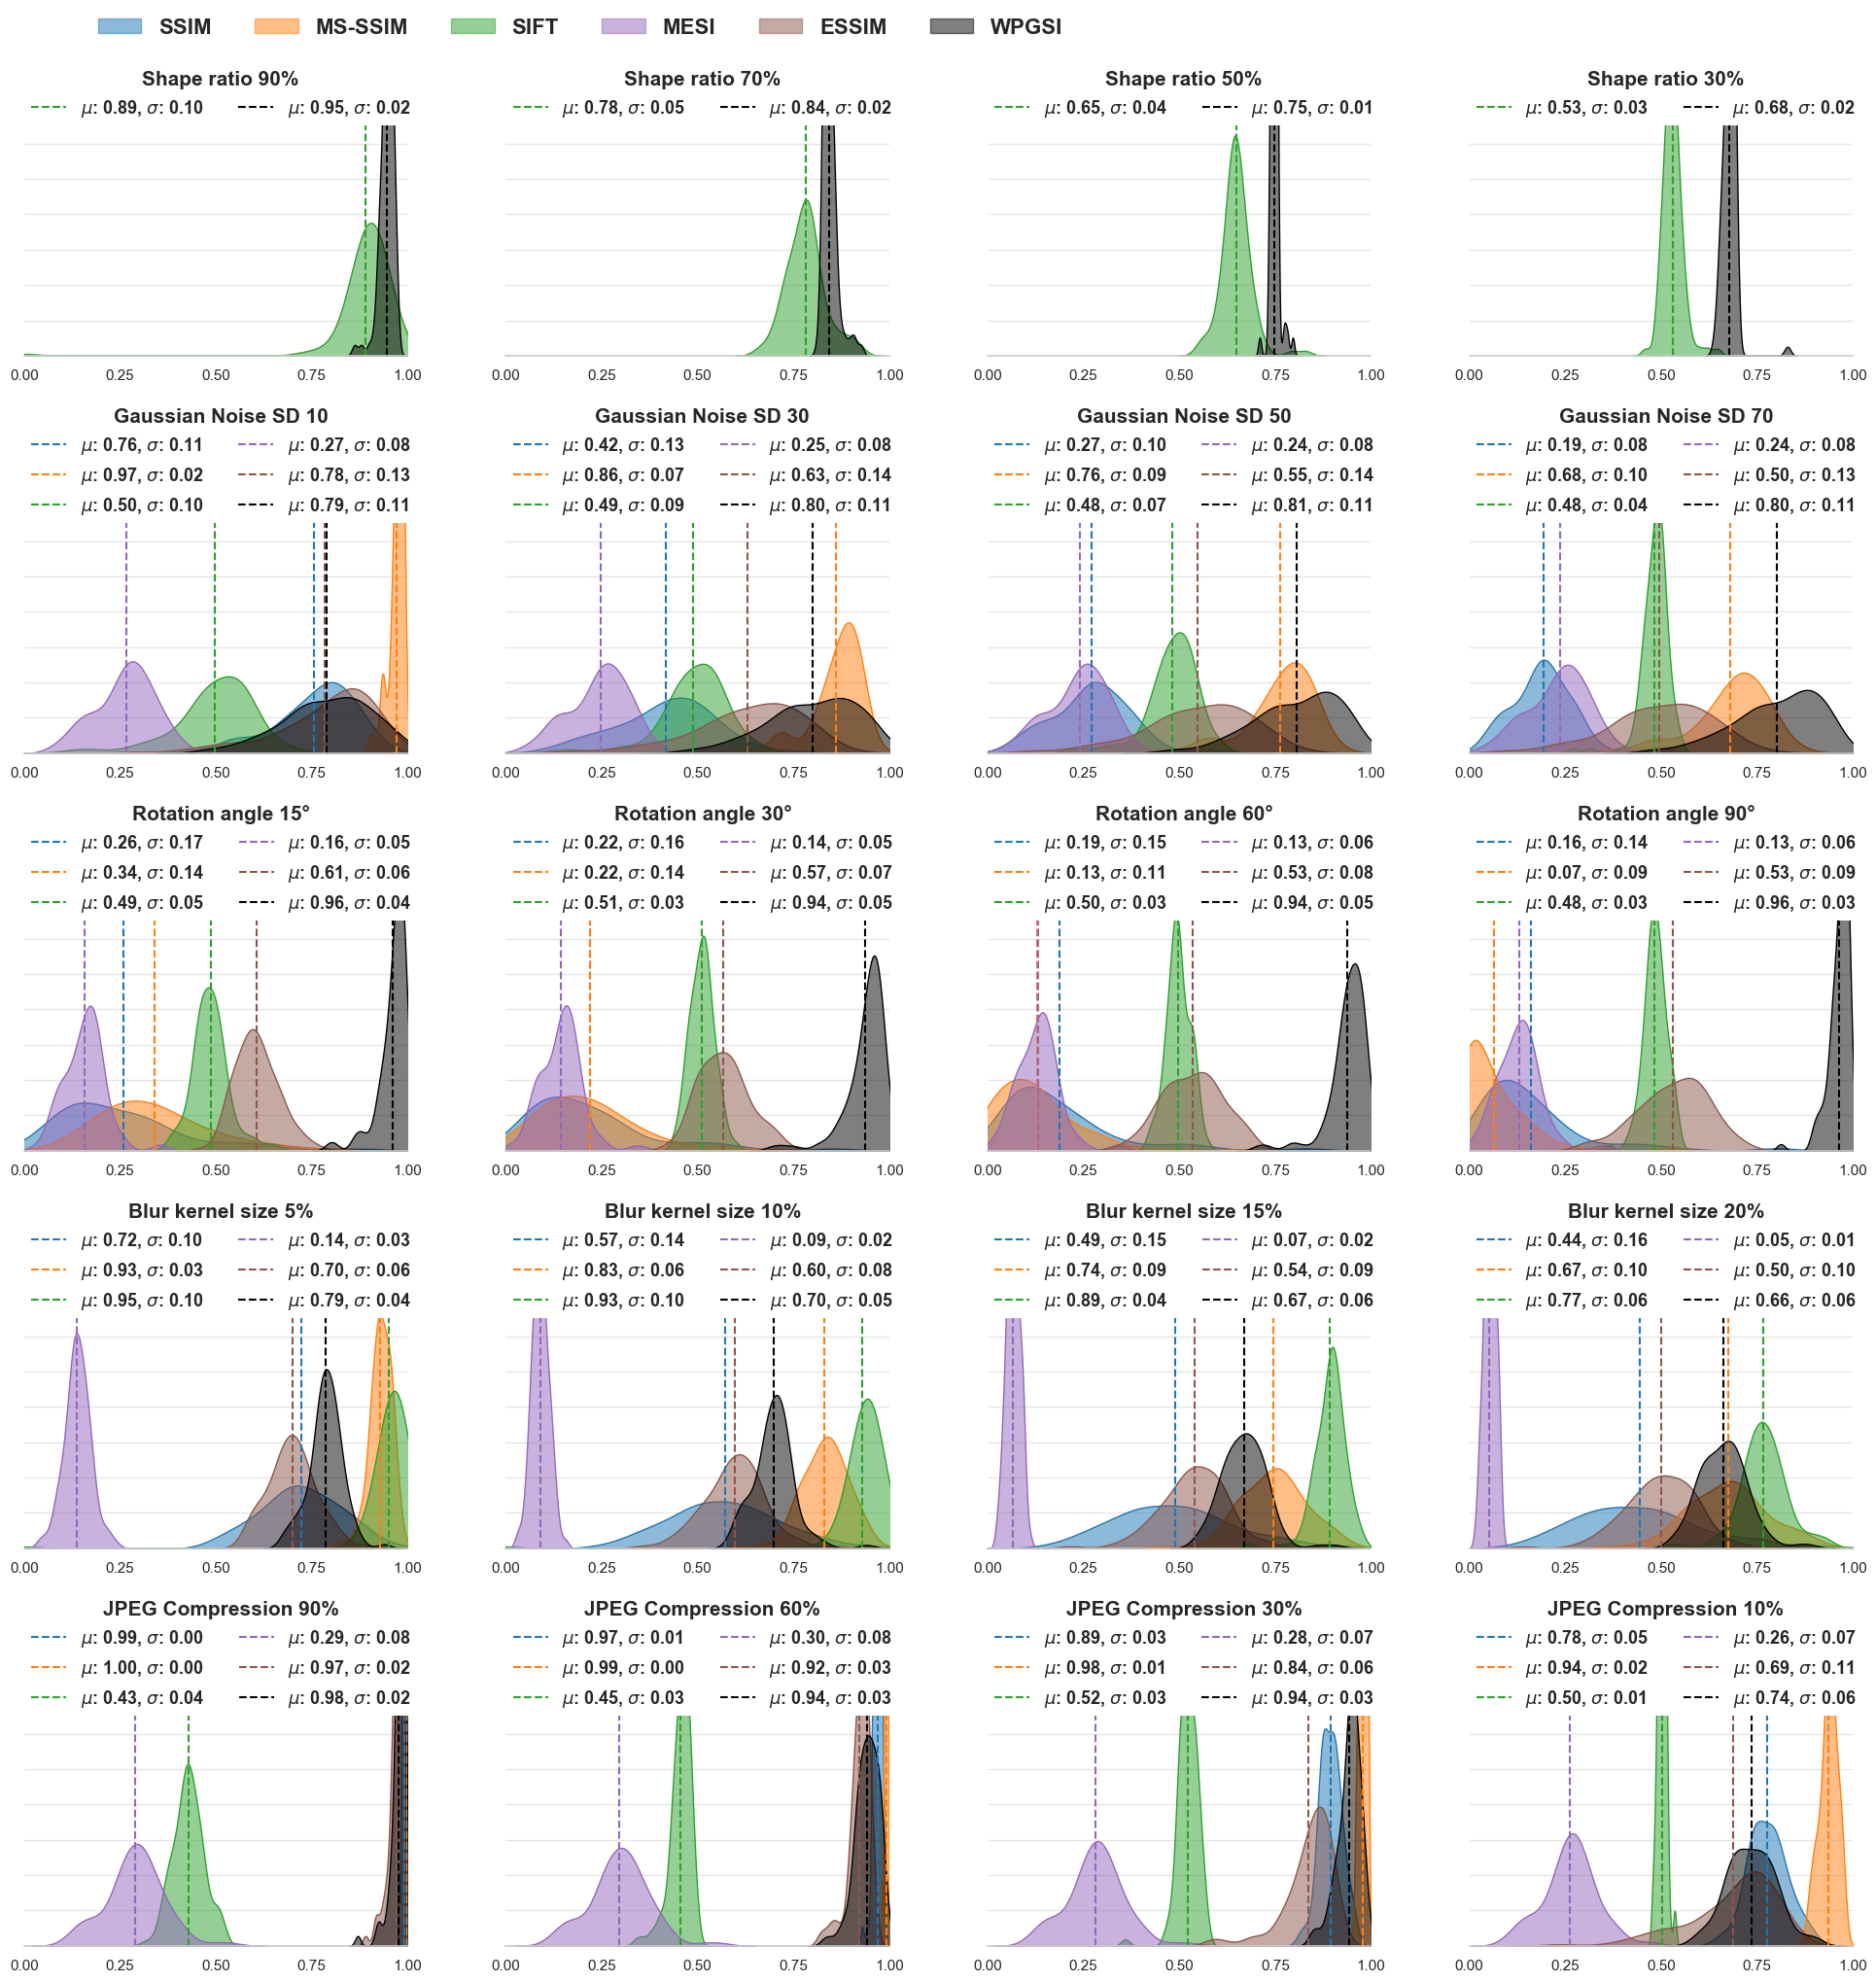

In [94]:
# Set up subplots for rotation and noise comparisons
fig, axes = plt.subplots(5, 4, figsize=(20, 20))

sns.set(style="whitegrid", palette="muted")

# Create super legend for density plots
patch_colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#9467bd', u'#8c564b', u'#000000', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf', u'#d62728']

methods = ['SSIM','MS-SSIM', 'SIFT', 'MESI', 'ESSIM', 'WPGSI']

handles = [ Patch(color=c, label=l) for c, l in zip(patch_colors,methods) ]
main_legend = fig.legend(handles=handles, bbox_to_anchor=(0.05, 1), loc=(0,1), ncol=7, prop={'weight':'bold','size':16}, frameon=False)

for lh in main_legend.legend_handles: 
    lh.set_alpha(0.5)

legend_titles = []

for i, (transformation, levels) in enumerate(transformation_levels.items()):
    legend_title_transformation=[]
    for l, level in enumerate(levels):
        
        if transformation == 'Gaussian Noise':
            legend_title_prefix, legend_title_suffix = 'Gaussian Noise SD', ''
        elif  transformation == 'Rotation':
            legend_title_prefix, legend_title_suffix = 'Rotation angle', '°'
        elif  transformation == 'JPEG Compression':
            legend_title_prefix, legend_title_suffix = 'JPEG Compression', '%'
        elif  transformation == 'Scaling':
            legend_title_prefix, legend_title_suffix = 'Shape ratio', '%'
        elif  transformation == 'Blur':
            legend_title_prefix, legend_title_suffix = 'Blur kernel size', '%'
        else:
            legend_title_prefix, legend_title_suffix = transformation, ''
        legend_title = legend_title_prefix + ' ' + str(level) + legend_title_suffix
        legend_title_transformation.append(legend_title)
        
        for m, M in enumerate(methods):
            if transformation == 'Scaling' and M in ['SSIM','MS-SSIM', 'MESI', 'ESSIM'] : continue
                
            
            sns.kdeplot(similarity_results[M][transformation][level], ax=axes[i, l], fill=True, alpha=0.5, color = patch_colors[m])
            mean = np.mean(similarity_results[M][transformation][level])
            sd = np.std(similarity_results[M][transformation][level])
            axes[i,l].axvline(mean, linestyle='--', label=fr'$ \mu $: {mean:.2f}, $ \sigma $: {sd:.2f}', color = patch_colors[m])
        
    legend_titles.append(legend_title_transformation)


# Plot length comparisons (bottom row)
for j in range(len(transformation_levels)):
    for i in range(4):
        # axes[j, i].axvline(0.25, linestyle='--', color='black', linewidth=1)
        # axes[j, i].axvline(0.5, linestyle='--', color='black', linewidth=1)
        # axes[j, i].axvline(0.75, linestyle='--', color='black', linewidth=1)
        axes[j, i].set_xlim(0,1)
        axes[j, i].set_xticks(np.linspace(0,1,5))
        axes[j, i].set_ylim(top=13)
        # axes[j, i].set_xlabel('Similarity')
        axes[j, i].set_ylabel('') # Density
        axes[j, i].legend(bbox_to_anchor=(0.0, 1), loc=(0,1), ncol=2, prop={'weight':'bold','size':13}, frameon=False)
        axes[j, i].get_legend().set_title(title=legend_titles[j][i], prop={'weight':'bold','size':15})
        axes[j, i].grid(False)
        axes[j, i].yaxis.grid(True,alpha=.5)
        axes[j, i].set_yticklabels([]) 
        axes[j, i].spines[['left', 'right', 'top']].set_visible(False)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig('imagenette_4_100.png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()
